### Load Modules, Data and preprocess data

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
# %%capture
# !pip install optuna

In [39]:
import csv
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import re
import pandas as pd
import re
import nltk
import transformers
import torch
# import optuna

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score
from sklearn.decomposition import PCA
from io import BytesIO
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer,TFAutoModel
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:

# file_path = os.path.join(os.path.expanduser("~"), "Desktop", "data_challenge", "train.txt")

# read training data
train_domains = list()
y_train = list()
with open("/content/drive/Othercomputers/My Computer/Masters_Staff/trimester_3/Data_challenge/project/data/train.txt", 'r') as f:
# with open("../../../../../data_challenge/train.txt", 'r') as f:
    for line in f:
        l = line.split(',') # domain names
        train_domains.append(l[0])
        y_train.append(l[1][:-1]) # topics of domain names

# read test data
test_domains = list()
with open("/content/drive/Othercomputers/My Computer/Masters_Staff/trimester_3/Data_challenge/project/data/test.txt", 'r') as f:
# with open("../../../../../data_challenge/test.txt", 'r') as f:
    for line in f:
        l = line.split(',')
        test_domains.append(l[0])

# create a directed graph
G = nx.read_edgelist('/content/drive/Othercomputers/My Computer/Masters_Staff/trimester_3/Data_challenge/project/data/edgelist.txt', delimiter=' ',
#                       create_using=nx.DiGraph())

# G = nx.read_edgelist('../../../../../data_challenge/edgelist.txt', delimiter=' ',
                      create_using=nx.DiGraph())

print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())

Number of nodes: 65208
Number of edges: 1642073


In [41]:
# read textual content of webpages of domain names
text = dict()
with zipfile.ZipFile('/content/drive/Othercomputers/My Computer/Masters_Staff/trimester_3/Data_challenge/project/data/domains.zip', "r") as zfile:

# with zipfile.ZipFile('../../../../../data_challenge/domains.zip', "r") as zfile:
    for filename in zfile.namelist():
        if re.search(r'\.zip$', filename) is not None:
            zfiledata = BytesIO(zfile.read(filename))
            with zipfile.ZipFile(zfiledata) as zfile2:
                text[filename[:-4]] = ''
                for name2 in zfile2.namelist():
                    file = zfile2.read(name2)
                    text[filename[:-4]] += file.decode('utf16') + ' '

# retrieve textual content of domain names of the training set
train_data = list()
for domain in train_domains:
    if domain in text:
        train_data.append(text[domain])
    else:
        train_data.append('')


# retrieve textual content of domain names of the test set
test_data = list()
for domain in test_domains:
    if domain in text:
        test_data.append(text[domain])
    else:
        test_data.append('')

# to reduce memory
text = None

In [42]:
from sklearn.model_selection import train_test_split

# create the training matrix. Each row corresponds to a web host.
# use the following 3 features for each web host:
# (1) int-degree of node
# (2) out-degree of node
# (3) average degree of neighborhood of node
X_train = np.zeros((len(train_domains), 3))
avg_neig_deg = nx.average_neighbor_degree(G, nodes=train_domains)
for i in range(len(train_domains)):
    X_train[i,0] = G.in_degree(train_domains[i])
    X_train[i,1] = G.out_degree(train_domains[i])
    X_train[i,2] = avg_neig_deg[train_domains[i]]
    # X_train[i,3] = round(deg_central_train[train_domains[i]], 5)

# create the test matrix. Use the same 3 features as above
Xtest = np.zeros((len(test_domains), 3))
avg_neig_deg = nx.average_neighbor_degree(G, nodes=test_domains)
for i in range(len(test_domains)):
    Xtest[i,0] = G.in_degree(test_domains[i])
    Xtest[i,1] = G.out_degree(test_domains[i])
    Xtest[i,2] = avg_neig_deg[test_domains[i]]

In [43]:
import pandas as pd
trains = pd.DataFrame({'domain_name':train_domains, 'in_deg':X_train[:,0], 'out_deg':X_train[:,1], 'avg_neig_deg':X_train[:,2], 'text':train_data, 'target':y_train})
tests = pd.DataFrame({'domain_name':test_domains, 'in_deg':Xtest[:, 0], 'out_deg':Xtest[:,1], 'avg_neig_deg':Xtest[:, 2], 'text':test_data})

In [44]:
# initialize objects
stemmer = WordNetLemmatizer()
stop_words = set(stopwords.words('greek'))

def preprocess(contents):
  docs = []

  for doc in contents:

      document = re.sub(r'\W', ' ', str(doc))# remove non-word (special) characters such as punctuation, numbers etc
      document = re.sub(r'\s+br\s+',' ', str(document)) # remove HTML <BR>
      document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document) # remove all single characters
      document = re.sub(r'\b\d+\b', ' ', document) # remove numbers
      document = re.sub(r'\s+', ' ', document, flags=re.I) #re.I -> ignore case  and substitute multiple spaces with single space
      document = document.lower() # convert to Lowercase
      word_list = word_tokenize(document)# split the document based on whitespaces (--> List of words)
      word_list = [word for word in word_list if word not in (stop_words)]
      # Lemmatization
      # word_list = [stemmer.lemmatize(word) for word in word_list]
      document = ' '.join(word_list) # reconstruct the document by joining the words on each whitespace
      docs.append(document) # append all documents into a list 'docs'

  return pd.Series(docs)

# preprocess texts
trains['text'] = preprocess(trains['text'])
tests['text'] = preprocess(tests['text'])


### TOKENIZATION + NaN-removal

In [45]:
trains['tokens']  = trains['text'].apply(lambda x: word_tokenize(x, language='greek'))
trains['tokens'][:2]

# filter out rows with empty lists in the 'tokens' column
trains = trains[trains['tokens'].apply(lambda x: len(x) > 0)]
trains = trains.reset_index(drop=True) # reset index of the filtered DataFrame
display(trains.info())
trains.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506 entries, 0 to 1505
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   domain_name   1506 non-null   object 
 1   in_deg        1506 non-null   float64
 2   out_deg       1506 non-null   float64
 3   avg_neig_deg  1506 non-null   float64
 4   text          1506 non-null   object 
 5   target        1506 non-null   object 
 6   tokens        1506 non-null   object 
dtypes: float64(3), object(4)
memory usage: 82.5+ KB


None

,domain_name,in_deg,out_deg,avg_neig_deg,text,target,tokens
833,newsone.gr,460.0,128.0,197.734375,http www newsone gr kosmos gallia zita sigklis...,3,"[http, www, newsone, gr, kosmos, gallia, zita,..."


### TF-IDF vectorization

In [46]:
# create the training matrix. Each row corresponds to a domain name and each column to a word present in at least 10 webpages
# and at most 50 webpages of domain names. The value of each entry in a row is equal to the tf-idf weight of that word in the
# corresponding domain
vec = TfidfVectorizer(ngram_range=(1, 3),
                      decode_error='ignore',
                      max_features=5000,
                      strip_accents='unicode',
                      min_df=10, max_df=50)

# vectorize the text sets
Xtf = vec.fit_transform(trains['text'])
# Xdev_tf = vec.transform(Xdev['text'])
# Xtest_tf = vec.transform(tests['text'])

# print("Train matrix dimensionality: ", Xtrain_tf.shape)
# print("Dev matrix dimensionality: ", Xdev_tf.shape)
# print("Test matrix dimensionality: ", Xtest_tf.shape)

### Sentence Transformer


In [47]:
%%capture
!pip install sentence_transformers

### BERT vectorization

In [48]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")
model = AutoModel.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")

def get_cls_sentence(sentence):
    # Tokenize input sentence and convert to tensor
    input_ids = torch.tensor([tokenizer.encode(sentence, add_special_tokens=True, max_length=512, truncation=True)])

    # Pass input through BERT model and extract embeddings for [CLS] token
    with torch.no_grad():
        outputs = model(input_ids)
        cls_embedding = outputs[0][:, 0, :]

    return cls_embedding.flatten()

trains['cls_bert'] = trains['text'].apply(lambda x: get_cls_sentence(x))
X_cls_bert = np.stack(trains['cls_bert'])


pytorch_model.bin:   0%|          | 0.00/454M [00:00<?, ?B/s]

### Visualization

In [49]:

kmeans = KMeans()

def eval_cluster(embedding):
    y_pred = kmeans.fit_predict(embedding)

    # evaluate the performance using ARI, NMI, and FMI
    ari = adjusted_rand_score(trains['target'], y_pred)
    nmi = normalized_mutual_info_score(trains['target'], y_pred)
    fmi = fowlkes_mallows_score(trains['target'], y_pred)

    # print Metrics scores
    print("Adjusted Rand Index (ARI): {:.3f}".format(ari))
    print("Normalized Mutual Information (NMI): {:.3f}".format(nmi))
    print("Fowlkes-Mallows Index (FMI): {:.3f}".format(fmi))

def dimension_reduction(embedding, method):

    pca = PCA(n_components=2, random_state=42)

    pca_vecs = pca.fit_transform(embedding)

    # save our two dimensions into x0 and x1
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]

    trains[f'x0_{method}'] = x0
    trains[f'x1_{method}'] = x1

def plot_pca(x0_name, x1_name, cluster_name, method):

    plt.figure(figsize=(12, 7))

    plt.title(f"TF-IDF + KMeans 20newsgroup clustering with {method}", fontdict={"fontsize": 18})
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})

    sns.scatterplot(data=trains, x=x0_name, y=x1_name, hue=cluster_name, palette="viridis")
    plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Adjusted Rand Index (ARI): 0.002
Normalized Mutual Information (NMI): 0.048
Fowlkes-Mallows Index (FMI): 0.314


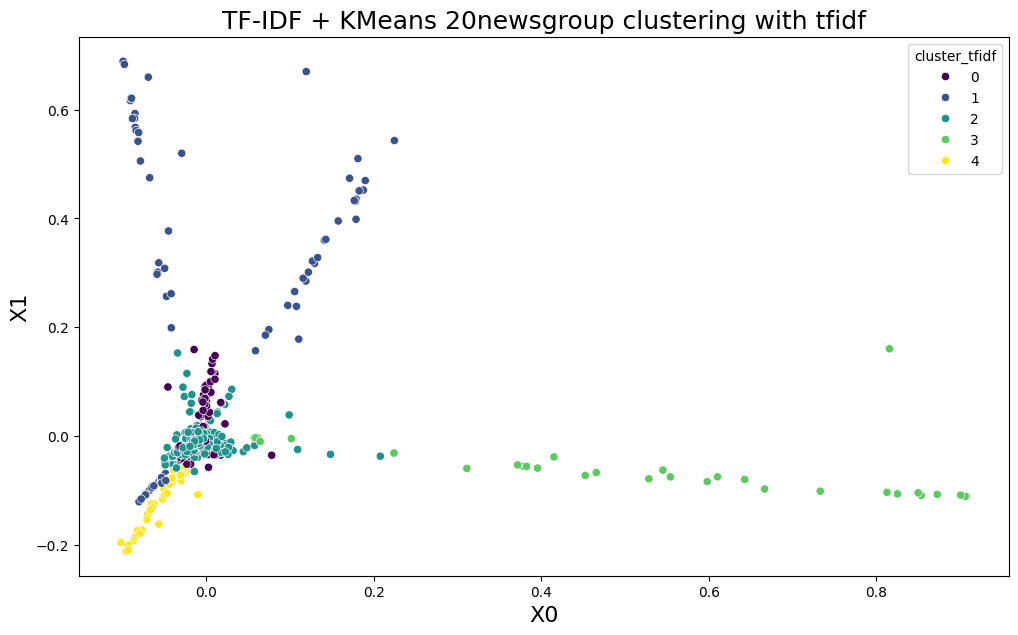

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Adjusted Rand Index (ARI): 0.083
Normalized Mutual Information (NMI): 0.083
Fowlkes-Mallows Index (FMI): 0.267


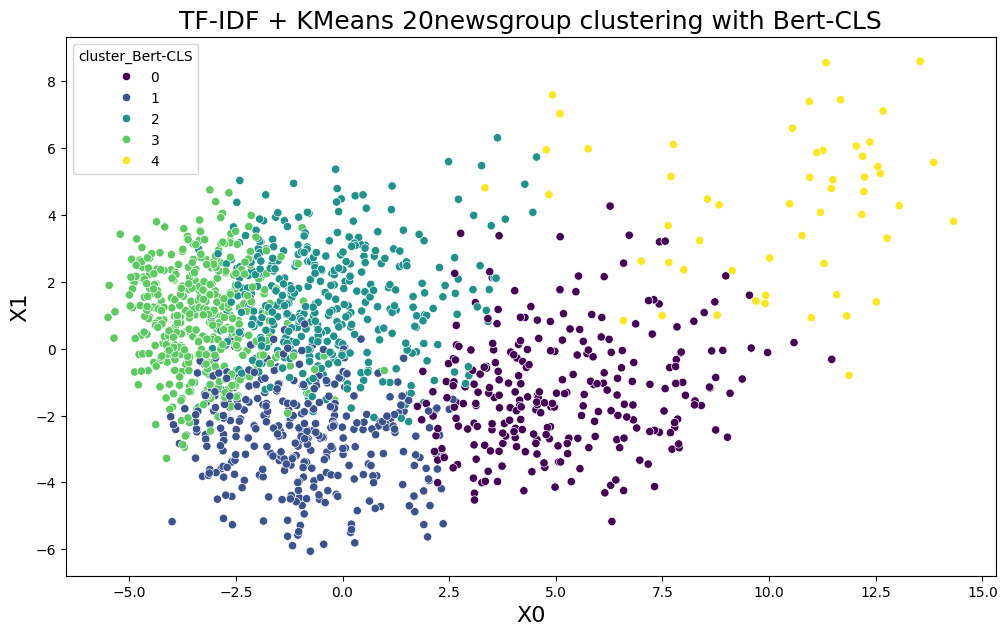

In [50]:
for embedding_and_method in [(Xtf.toarray(), 'tfidf'), ((X_cls_bert, 'Bert-CLS')) ]:
    embedding, method = embedding_and_method[0], embedding_and_method[1]

    # initialize kmeans with 3 centroids
    kmeans = KMeans(n_clusters=5, random_state=42)

    # fit the model
    kmeans.fit(embedding)

    # store cluster labels in a variable
    clusters = kmeans.labels_

    # Assign clusters to our dataframe
    clusters_result_name = f'cluster_{method}'
    trains[clusters_result_name] = clusters

    eval_cluster(embedding)

    dimension_reduction(embedding, method)

    plot_pca(f'x0_{method}', f'x1_{method}', cluster_name=clusters_result_name, method=method)

In [51]:
print(X_cls_bert.shape)

(1506, 768)


In [52]:
Xtr_bert, Xde_bert, y_train, y_dev = train_test_split(X_cls_bert, trains['target'], test_size=0.10, random_state=42)

In [53]:
import gc
gc.collect()

406

In [54]:
from sklearn.model_selection import train_test_split

Xsplit = trains.drop(['target'], axis=1)

# split data to train and dev
Xtrain, Xdev, ytrain, ydev = train_test_split(
    Xsplit['text'],
    trains['target'],
    test_size=0.10, random_state=42)

print("Train matrix dimensionality: ", type(Xtrain))
print("Dev matrix dimensionality: ", type(Xdev))


# import pandas as pd
# from sklearn.utils import Bunch

# def series_to_bunch(series, target_values, target_name='target', data_name='data', target_key='target'):
#     """
#     Convert a pandas Series to a scikit-learn Bunch object.

#     Parameters:
#     - series: pandas Series object containing text data.
#     - target_values: List of target values.
#     - target_name: Optional. Name for the target variable.
#     - data_name: Optional. Name for the data attribute in the Bunch object.
#     - target_key: Optional. Key name for the target variable in the Bunch object.

#     Returns:
#     - Bunch object containing the Series data and target values.
#     """
#     # Create Bunch object
#     bunch = Bunch()
#     bunch[data_name] = series
#     bunch[target_key] = target_values

#     return bunch

# # Example usage:
# text_data = Xtrain
# target_values = ytrain  # list of target values
# Xtrain = series_to_bunch(text_data, target_values)

# dev_txt_data = Xdev
# target_values_dev = ydev
# Xdev = series_to_bunch(dev_txt_data,target_values_dev)


Train matrix dimensionality:  <class 'pandas.core.series.Series'>
Dev matrix dimensionality:  <class 'pandas.core.series.Series'>


### Bert Classification Task

In [55]:
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")
model = TFAutoModel.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")

def tokenize_text(data, tokenizer, max_length=250):
  return tokenizer(data, add_special_tokens=True, padding='max_length',
                   max_length=max_length, truncation=True, return_tensors='tf')

# tokenize
bert_train = tokenize_text(Xtrain.tolist(), tokenizer)
bert_dev = tokenize_text(Xdev.tolist(), tokenizer)
bert_test = tokenize_text(tests['text'].tolist(), tokenizer)


Some layers from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [56]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
ytrain_en = encoder.fit_transform(np.array(ytrain).reshape(-1, 1)) # reshape y_train
ydev_en = encoder.fit_transform(np.array(ydev).reshape(-1, 1)) # reshape as y_dev

In [57]:
from sklearn.metrics import f1_score, recall_score, precision_score
import os
import numpy as np

class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(tf.nn.softmax(self.model.predict(self.validation_data[0]),
                                              axis=-1), -1)
        val_targ = self.validation_data[1]
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)
        val_targ = tf.cast(val_targ, dtype=tf.float32)


        _val_f1 = f1_score(val_targ, val_predict, average="weighted")
        _val_recall = recall_score(val_targ, val_predict, average="weighted")
        _val_precision = precision_score(val_targ, val_predict, average="weighted")

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

In [58]:
import tensorflow as tf
class BERTClassifier(tf.keras.Model):
  def __init__(self, bert, num_classes, freeze=False, apply_dropout=True):
    super().__init__()
    self.bert = bert
    self.apply_dropout = apply_dropout
    self.bert.trainable = True
    if freeze:
        self.bert.trainable = False
    self.pool = tf.keras.layers.GlobalMaxPooling1D(name='max_pool')
    self.dropout = tf.keras.layers.Dropout(0.5, name='dropout')
    self.clf = tf.keras.layers.Dense(num_classes, name='clf',
                                     activation='softmax')

  def call(self, inputs, training=None):
    # input_ids, attention_mask = inputs
    x = self.bert(inputs, training=training)
    x = self.pool(x.last_hidden_state)
    if self.apply_dropout:
        x = self.dropout(x, training=training)
    x = self.clf(x, training=training)
    return x

  def print_summary(self, line_length=None, positions=None, print_fn=None):
    # Fake forward pass to build graph
    x = np.zeros((1, 250), dtype=np.int32)
    self.predict([x, x])
    self.summary(line_length=line_length, positions=positions,
                 print_fn=print_fn)

In [59]:
bert_classifier = BERTClassifier(model,
                                 9,
                                 freeze=False, apply_dropout=True)
print(bert_classifier.print_summary())

bert_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
                        loss=tf.keras.losses.CategoricalCrossentropy(
                       from_logits=False
                       ),
                   metrics=[tf.keras.metrics.CategoricalAccuracy()])

history = bert_classifier.fit(x=[bert_train['input_ids'],
                  bert_train['attention_mask']
                  ],
                  y=ytrain_en, batch_size=16, verbose=1,
                  validation_data=([bert_dev['input_ids'],
                                    bert_dev['attention_mask']],
                                    ydev_en),
                  callbacks = [Metrics(([bert_dev['input_ids'],
                                          bert_dev['attention_mask']],
                                         ydev_en))],
               shuffle=True,
               epochs=12,)

1/1 [==============================] - 18s 18s/step
Model: "bert_classifier_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model_1 (TFBertMod  multiple                  112921344 
 el)                                                             
                                                                 
 max_pool (GlobalMaxPooling  multiple                  0         
 1D)                                                             
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 clf (Dense)                 multiple                  6921      
                                                                 
Total params: 112928265 (430.79 MB)
Trainable params: 112928265 (430.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

5/5 [==============================] - 13s 495ms/step
 — val_f1: 0.106030 — val_precision: 0.066708 — val_recall: 0.258278
85/85 [==============================] - 148s 1s/step - loss: 2.7787 - categorical_accuracy: 0.2133 - val_loss: 2.5483 - val_categorical_accuracy: 0.2583 - val_f1: 0.1060 - val_recall: 0.2583 - val_precision: 0.0667
Epoch 2/12


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 [==============================] - 3s 504ms/step
 — val_f1: 0.169978 — val_precision: 0.116998 — val_recall: 0.317881
85/85 [==============================] - 76s 900ms/step - loss: 2.2847 - categorical_accuracy: 0.2708 - val_loss: 2.3425 - val_categorical_accuracy: 0.3179 - val_f1: 0.1700 - val_recall: 0.3179 - val_precision: 0.1170
Epoch 3/12


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 [==============================] - 3s 507ms/step
 — val_f1: 0.572132 — val_precision: 0.685435 — val_recall: 0.602649
85/85 [==============================] - 76s 898ms/step - loss: 1.6725 - categorical_accuracy: 0.4627 - val_loss: 1.3879 - val_categorical_accuracy: 0.6026 - val_f1: 0.5721 - val_recall: 0.6026 - val_precision: 0.6854
Epoch 4/12


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 [==============================] - 3s 508ms/step
 — val_f1: 0.639098 — val_precision: 0.720987 — val_recall: 0.655629
85/85 [==============================] - 76s 898ms/step - loss: 1.0636 - categorical_accuracy: 0.6716 - val_loss: 1.3859 - val_categorical_accuracy: 0.6556 - val_f1: 0.6391 - val_recall: 0.6556 - val_precision: 0.7210
Epoch 5/12
5/5 [==============================] - 3s 508ms/step
 — val_f1: 0.671176 — val_precision: 0.711064 — val_recall: 0.682119
85/85 [==============================] - 76s 897ms/step - loss: 0.6978 - categorical_accuracy: 0.7867 - val_loss: 1.3435 - val_categorical_accuracy: 0.6821 - val_f1: 0.6712 - val_recall: 0.6821 - val_precision: 0.7111
Epoch 6/12
5/5 [==============================] - 3s 508ms/step
 — val_f1: 0.598569 — val_precision: 0.698931 — val_recall: 0.622517
85/85 [==============================] - 76s 897ms/step - loss: 0.4552 - categorical_accuracy: 0.8502 - val_loss: 1.7336 - val_categorical_accuracy: 0.6225 - val_f1: 0.5986 - v

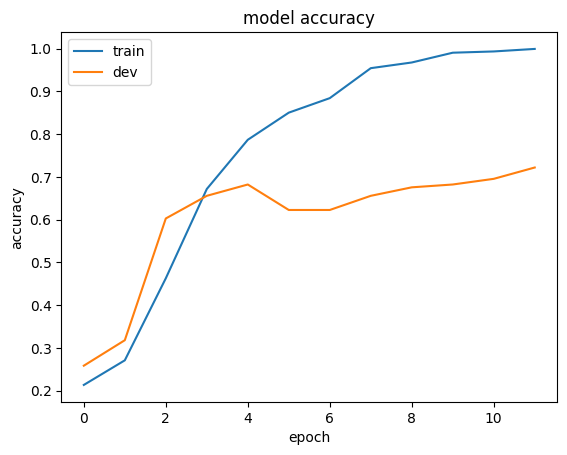

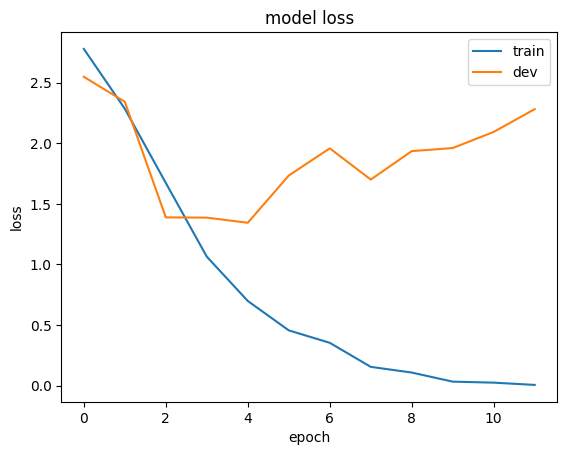

In [60]:
%matplotlib inline
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

In [61]:
bert_pred = tf.nn.softmax(bert_classifier.predict([bert_dev['input_ids'],
                                                    bert_dev['attention_mask']]), axis=-1)

5/5 [==============================] - 3s 506ms/step


In [62]:
# cross-entropy loss for multi-class classification
def multiclass_cross_entropy(y_true, y_pred_prob):
    epsilon = 1e-15  # small value to prevent log(0)
    # clip predicted probabilities to avoid log(0)
    y_pred_prob = np.clip(y_pred_prob, epsilon, 1 - epsilon)
    # compute cross-entropy loss
    loss = -np.mean(np.sum(y_true * np.log(y_pred_prob), axis=1))
    return loss

bert_ce_loss = multiclass_cross_entropy(ydev_en, bert_pred)
print(f"Cross-entropy loss with bert on dev set: {bert_ce_loss}")

Cross-entropy loss with bert on dev set: 1.6578733376319834
